### Import

In [1]:
import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
import seaborn as sns
from scipy import stats
from collections import defaultdict

import pandas as pd
import numpy as np
from os import listdir
import json

from utils.plotting import *

# Read data

In [2]:
def read_data(folder):
    # Initialize list of dataframes that we will concatenate.
    all_data = []
    
    # Get list of all JSON results files in the folder.
    files_to_read = [f for f in listdir(folder) if f.endswith(".json")]

    # Read each file into a single dataframe.
    for f in files_to_read:
        with open(folder + "/" + f, "r") as fp:
            data = json.load(fp)
        results = pd.DataFrame(data["results"])
        for k, v in data["meta"].items():
            if not isinstance(v, list):
                results[k] = v
        results["corpus"] = f.split("_")[0]
        all_data.append(results)
    df = pd.concat(all_data)
    
    # Rename variables for better-looking figures.
    df["model"] = df.model.apply(pretty_model)
    df["eval_type"] = df.eval_type.apply(pretty_evaltype)

    # Add revision / checkpoint name for Pythia models
    df['model_with_revision'] = df.apply(
        lambda row: row["model"] + "\n" + row["revision"] if "Pythia" in row["model"] or "OLMo" in row["model"] else row["model"], axis=1
        )

    # Update model_name to include revision and quantization when applicable
    df['model_with_revision'] = df.apply(
        lambda row: f"{row['model']}" + 
                    (f"-{row['quantization']}" if row['quantization'] in ["4bit", "8bit"] else "") + 
                    (f"\n{row['revision']}" if "Pythia" in row["model"] or "OLMo" in row["model"] else "") 
                    if "Pythia" in row["model"] or "OLMo" in row["model"] else row["model"],
        axis=1
    )

    return df

# Read results for all tasks.
RESULT_DIR = "results"
TASKS = [
    "exp1_word-prediction",
    "exp2_word-comparison",
    "exp3a_sentence-judgment",
    "exp3b_sentence-comparison"
]
RESULTS = {
    task.split("_")[0]: read_data(f"{RESULT_DIR}/{task}")
    for task in TASKS
}

# Copy direct data from Experiment 3a to 3b.
_3a = RESULTS["exp3a"].copy()
_3a_direct = _3a[_3a.eval_type=="Direct"]
_3b = RESULTS["exp3b"].copy()
_3b = pd.concat([_3a_direct, _3b])
RESULTS["exp3b"] = _3b

# Figure 2: Task performance

In [3]:
def compute_accuracy_metric(df, task):
    if task == "exp1":
        pass
    
    elif task == "exp2":
        df["model_prefers_good_continuation"] = \
            (df["logprob_of_good_continuation"] > df["logprob_of_bad_continuation"])
    
    elif task == "exp3b":
        def _success_criterion_sentence(row):
            if row.eval_type == "Direct":
                return (row.logprob_of_good_sentence > row.logprob_of_bad_sentence)
            else:
                return (row.logprob_of_good_continuation > row.logprob_of_bad_continuation)
        df["model_prefers_good_sentence"] = df.apply(_success_criterion_sentence, axis=1)
    
    else:
        # Accuracy for "direct"
        df["model_prefers_good_sentence"] = df.apply(
            lambda row: row.logprob_of_good_sentence > row.logprob_of_bad_sentence if row.eval_type == "Direct" else None,
            axis=1
        )
        # True positive
        df["model_prefers_yes_good"] = df.apply(
            lambda row: row.logprob_of_yes_good_sentence > row.logprob_of_no_good_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # True negative
        df["model_prefers_no_bad"] = df.apply(
            lambda row: row.logprob_of_no_bad_sentence > row.logprob_of_yes_bad_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # False positive
        df["model_prefers_yes_bad"] = df.apply(
            lambda row: row.logprob_of_yes_bad_sentence > row.logprob_of_no_bad_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
        # False negative
        df["model_prefers_no_good"] = df.apply(
            lambda row: row.logprob_of_no_good_sentence > row.logprob_of_yes_good_sentence if row.eval_type != "Direct" else None,
            axis=1
        )
    return df

In [4]:
for task, df in RESULTS.items():
    RESULTS[task] = compute_accuracy_metric(df, task)

## Experiment 1: Word prediction

d:\Uni\metalinguistic-prompting\utils\plotting.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=25, ha="right")
d:\Uni\metalinguistic-prompting\utils\plotting.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=25, ha="right")


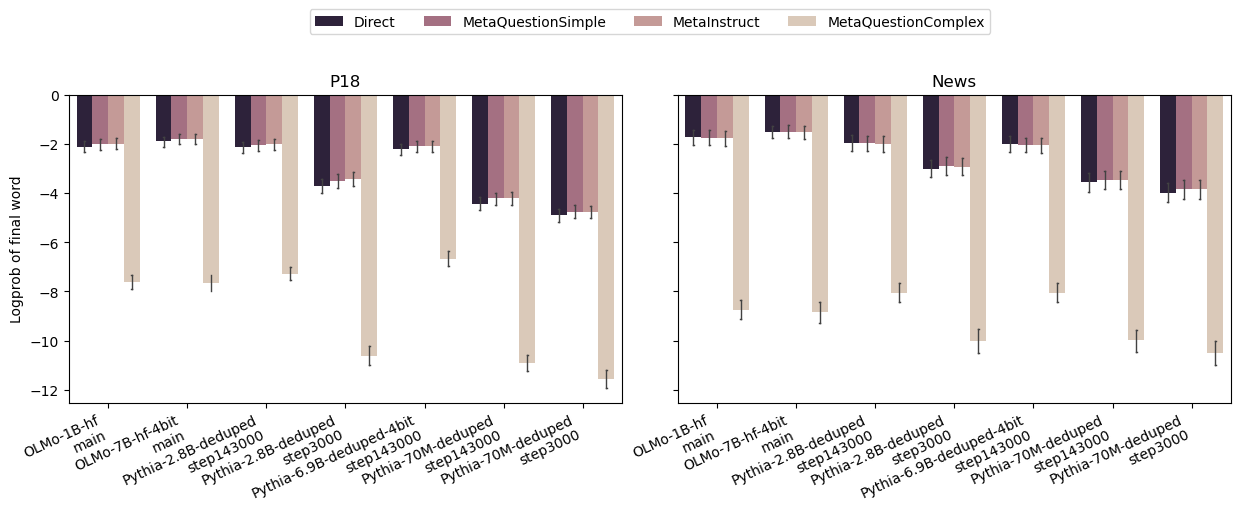

In [5]:
_df = RESULTS["exp1"]
metric = "logprob_of_gold_continuation"
metric_label = "Logprob of final word"
kwargs = dict(
    x="model_with_revision",
    hue="eval_type",
    xlabel="",
    hue_order=EVAL_TYPES,
    palette=EVAL_TYPE_PAL
)

########################################
# Average over datasets
########################################

# ax = plot_metric(_df, metric, ylabel=metric_label, **kwargs)
# ax.get_legend().remove()
# plt.gcf().set_size_inches(*BARPLOT_SIZE)
# # render("exp1_task_performance.pdf")

# plt.show()

########################################
# Break down by dataset
########################################

# Set up subplots.
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=False, figsize=(15,4))

# Dataset 1: P18
ax1 = plot_metric(
    _df[_df.corpus=="p18"],
    metric,
    ax=axes[0],
    ylabel=metric_label,
    **kwargs
)
ax1.get_legend().remove()
ax1.set_title("P18")

# Dataset 2: News
ax2 = plot_metric(
    _df[_df.corpus=="news"],
    metric,
    ax=axes[1],
    ylabel="",
    **kwargs
)
ax2.set_title("News")
ax2.legend(loc='upper center', bbox_to_anchor=(-0.05, 1.3),
          ncol=len(EVAL_TYPES))

plt.subplots_adjust(wspace=0.1)
# render("exp1_task_performance_bydataset.pdf")

## Experiment 2: Word comparison

Updated

d:\Uni\metalinguistic-prompting\utils\plotting.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=25, ha="right")


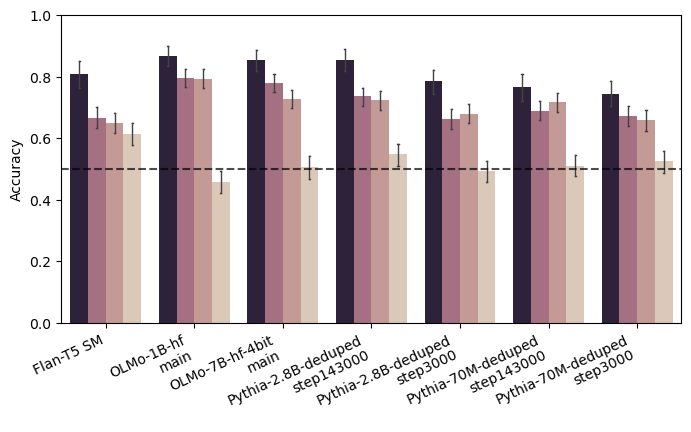

In [6]:
ax = plot_metric(
    RESULTS["exp2"],
    "model_prefers_good_continuation",
    x="model_with_revision",
    hue="eval_type",
    xlabel="",
    ylabel="Accuracy",
    # legend_pos="outside",
    hue_order=EVAL_TYPES,
    chance=0.5,
    ylim=(0,1)
)
ax.get_legend().remove()
plt.gcf().set_size_inches(*BARPLOT_SIZE)
# render("exp2_task_performance.pdf")

## Experiment 3b: Sentence comparison

NOTE: It's simpler to generate the plots for Experiment 3b than the plots for Experiment 3a, so we'll do it first.

d:\Uni\metalinguistic-prompting\utils\plotting.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=25, ha="right")
d:\Uni\metalinguistic-prompting\utils\plotting.py:165: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=25, ha="right")


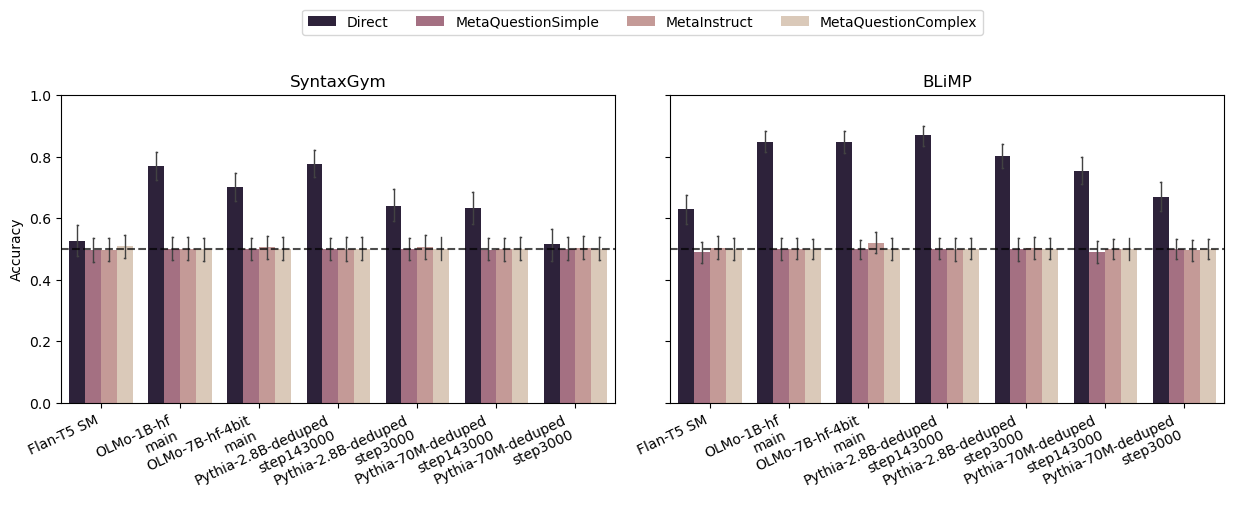

In [7]:
_df = RESULTS["exp3b"]
metric = "model_prefers_good_sentence"
metric_label = "Accuracy"
kwargs = dict(
    x="model_with_revision",
    hue="eval_type",
    xlabel="",
    hue_order=EVAL_TYPES,
    chance=0.5,
    ylim=(0,1),
)

########################################
# Average over datasets
########################################

# ax = plot_metric(_df, metric, ylabel=metric_label, **kwargs)
# ax.get_legend().remove()
# plt.gcf().set_size_inches(*BARPLOT_SIZE)
# # render("exp3b_task_performance.pdf")

# plt.show()

########################################
# Break down by dataset
########################################

# Set up subplots.
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=False, figsize=(15,4))

# Dataset 1: SyntaxGym
ax1 = plot_metric(
    _df[_df.corpus=="syntaxgym"],
    metric,
    ylabel=metric_label,
    ax=axes[0],
    **kwargs
)
ax1.get_legend().remove()
ax1.set_title("SyntaxGym")

# Dataset 2: BLiMP
ax2 = plot_metric(
    _df[_df.corpus=="blimp"],
    metric,
    ylabel="",
    ax=axes[1],
    **kwargs
)
ax2.set_title("BLiMP")
ax2.legend(loc='upper center', bbox_to_anchor=(-0.05, 1.3),
          ncol=len(EVAL_TYPES))

plt.subplots_adjust(wspace=0.1)
# render("exp3b_task_performance_bydataset.pdf")